# Load in Packages

In [293]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.signal import fftconvolve
import matplotlib.colors as col
from matplotlib.patches import Rectangle
from matplotlib.ticker import FormatStrFormatter
from skimage.draw import disk
from scipy.optimize import curve_fit
from scipy.integrate import solve_ivp
import csv
import xarray as xr
from collections import defaultdict

import sys, os
sys.path.append(os.path.abspath("R:\Lawson\mpes-analysis"))  # or full path to project
#sys.path.append(os.path.abspath("/Users/lawsonlloyd/GitHub/mpes-analysis"))  # or full path to project

import mpes
from Loader import DataLoader
from mpes import cmap_LTL, cmap_LTL2
import phoibos

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Load Path and Scan Database Information

In [5]:
#%% Load Data Scan Info

filename = '2024 Bulk CrSBr Phoibos.csv'

scan_info = {}
data_path = 'R:\Lawson\Data\phoibos'
data_path_info = 'R:\Lawson\CrSBr-analysis-manuscript\Analysis Scripts'

#data_path = '/Users/lawsonlloyd/Desktop/Data/phoibos'
#data_path_info = '/Users/lawsonlloyd//GitHub/CrSBr-analysis-manuscript'

energy_offset, delay_offset, force_offset = 19.62,  0, False

scan_info = phoibos.get_scan_info(data_path_info, filename, {})

### Define Exponential Fitting Functions


In [6]:

%matplotlib inline

# Define the monoexponential decay function (Exciton)
def monoexp(t, A, tau):
    return A * np.exp(-t / tau) * (t >= 0)  # Ensure decay starts at t=0

# Define the biexponnential decay function (Exciton)    
def biexp(t, A, tau1, B, tau2):
    return ( A * np.exp(-t / tau1) + B * np.exp(-t / tau2))  * (t >= 0)  # Ensure decay starts at t=0

# Define the conduction band model: exponential rise + decay
def exp_rise_monoexp_decay(t, C, tau_rise, tau_decay1):
    return C * (1 - np.exp(-t / tau_rise)) * (np.exp(-t / tau_decay1)) * (t >= 0)

def exp_rise_biexp_decay(t, C, tau_rise, D, tau_decay1, tau_decay2):
    return C * (1 - np.exp(-t / tau_rise)) * (D * np.exp(-t / tau_decay1) + (1-D) * np.exp(-t / tau_decay2)) * (t >= 0)

# Define the Instrumental Response Function (IRF) as a Gaussian
def IRF(t, sigma_IRF):
    return np.exp(-t**2 / (2 * sigma_IRF**2)) / (sigma_IRF * np.sqrt(2 * np.pi))

# Convolution of the signal with the IRF
def convolved_signal(t, signal_function, sigma_IRF, *params):
    dt = np.mean(np.diff(t))  # Time step
    signal = signal_function(t, *params)  # Compute signal
    irf = IRF(t - t[len(t)//2], sigma_IRF)  # Shift IRF to center
    irf /= np.sum(irf) * dt  # Normalize IRF
    convolved = fftconvolve(signal, irf, mode='same') * dt  # Convolve with IRF
    return convolved

def convolved_signal_2(t, signal_function, sigma_IRF, *params):
    dt = np.mean(np.diff(t))

    # Extend the time axis on both sides to avoid edge effects
    pad_width = int(5 * sigma_IRF / dt)  # enough padding for Gaussian tail
    t_pad = np.linspace(t[0] - pad_width * dt, t[-1] + pad_width * dt, len(t) + 2 * pad_width)

    # Evaluate signal on the extended time axis
    signal_ext = signal_function(t_pad, *params)

    # Create centered Gaussian IRF
    irf = np.exp(-((t_pad - np.median(t_pad)) ** 2) / (2 * sigma_IRF ** 2))
    irf /= np.sum(irf) * dt  # Normalize area under the IRF to 1

    # Convolve using FFT
    conv_ext = fftconvolve(signal_ext, irf, mode='same') * dt

    # Trim back to original t range
    convolved = conv_ext[pad_width : -pad_width]
    
    return convolved


# Fitting the Data


### Independent Fitting EX and CBM Signals to Exponentials


0

Fit Results for model: biexp
----------------------------------------
A          =     0.0000 ±  1.4106
tau_decay1 =  1924.0403 ±  0.0000
B          =     0.8389 ±  1.3752
tau_decay2 = 10890.5578 ± 63214.7827
----------------------------------------

Fit Results for model: exp_rise_monoexp_decay
----------------------------------------
A          =     0.1967 ±  0.0346
tau_rise   =   191.5632 ± 68.5389
tau_decay1 = 15000.0000 ± 35252.4872
----------------------------------------
t0 = 136.6 +/- 16.1 fs
width = 204.5 +/- 32.4 fs
1

Fit Results for model: biexp
----------------------------------------
A          =     0.0722 ± 72.1734
tau_decay1 =  1999.9836 ± 846934.5539
B          =     0.8026 ± 72.2119
tau_decay2 =  7667.9471 ± 861943.3044
----------------------------------------

Fit Results for model: exp_rise_monoexp_decay
----------------------------------------
A          =     0.3100 ±  0.0282
tau_rise   =   113.1064 ± 28.8677
tau_decay1 =  4149.1426 ± 1639.8207
--------------

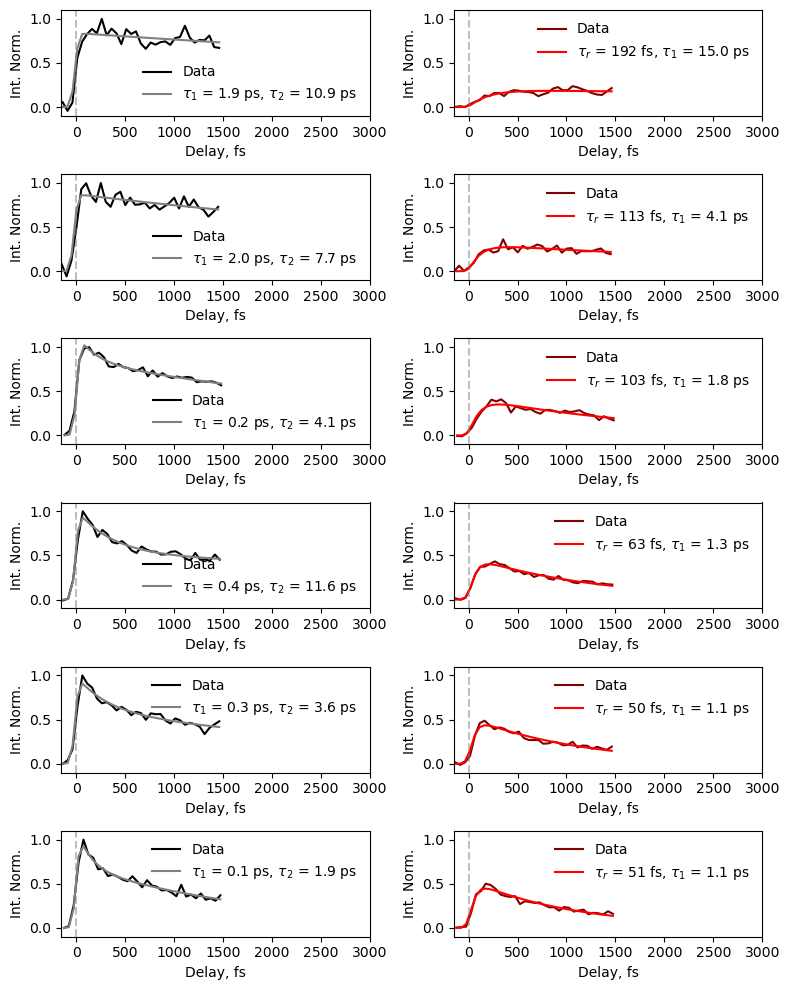

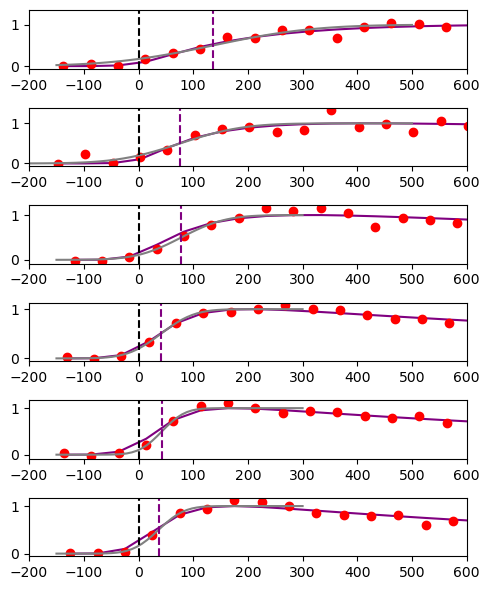

In [385]:
# Specify Data and Scan Paramters
scans = [9219, 9217, 9218, 9216, 9220, 9228]
power = [8.3, 20.9, 41.7, 65.6, 83.2, 104.7]
fluences = [.2, .35, .8, 1.74, 2.4, 2.9]

E, E_int = [1.35, 2.1], 0.1 # center energies, half of full E integration range

delay_limit = [-150, 1500] # Truncate delay traces
convolve_IRF, fwhm_IRF = True, 80
sigma_IRF = fwhm_IRF/2.355   # Fixed IRF width (fs)

# Exciton Fitting Model
ex_model = 'biexp'
p0_exciton = (.2, 750, 1, 5000) #A, tau1, B, tau2
lower_bounds_ex, upper_bounds_ex = (0, 0, 0, 0), (3, 2000, 3, 30000)

# CBM Fitting Model
cbm_model = 'exp_rise_monoexp_decay'
#cbm_model = 'exp_rise_biexp_decay'

if cbm_model == 'exp_rise_monoexp_decay':
    p0_cbm = (2, 150, 5000) #A', 'tau_rise', 'tau_decay'
    lower_bounds_cbm, upper_bounds_cbm = (0, 0, 500), (2, 1000, 15000)
elif cbm_model == 'exp_rise_biexp_decay':
    p0_cbm = (1, 200, 0, 2000, 5000) #C, tau_rise, D, tau_decay1, tau_decay2
    lower_bounds_cbm, upper_bounds_cbm = (0, 0, 0, 0, 3000), (3, 500,  1, 5000, 15000)

# Initalize Fitting Arrays
params_ex_all, errors_ex_all = defaultdict(list), defaultdict(list)
params_cbm_all, errors_cbm_all = defaultdict(list), defaultdict(list)
ratios = np.zeros(len(scans))
cbm_t0s = np.zeros((len(scans),4))

# Initialize Figure
fig, ax = plt.subplots(6, 2)
fig.set_size_inches(8, 10, forward=False)
ax = ax.flatten()

fig2, ax2 = plt.subplots(6, 1)
fig2.set_size_inches(5, 6, forward=False)
ax2 = ax2.flatten()

# Plot and Perform Fits
for s in range(len(scans)):
    print(s)

    # Load in the Data
    res = phoibos.load_data(data_path, scans[s], force_offset=False, scan_info = scan_info, energy_offset=19.7, delay_offset=0)
    delay_axis = res.delay.values
    delay_axis = res.delay.loc[{"delay":slice(delay_limit[0], delay_limit[1])}].values

    trace_1 = mpes.get_time_trace(res, E[0], E_int, 0, 24, norm_trace = False, subtract_neg = True, neg_delays = [-600, -200])
    trace_1 = trace_1.loc[{"delay":slice(delay_limit[0],delay_limit[1])}]

    trace_2 = mpes.get_time_trace(res, E[1], E_int, 0, 24, norm_trace = False, subtract_neg = True, neg_delays = [-600, -200])
    trace_2 = trace_2.loc[{"delay":slice(delay_limit[0],delay_limit[1])}]

    norm_factor = np.max(trace_1)
    trace_1 = trace_1/norm_factor
    trace_2 = trace_2/norm_factor

    if s > 8:
        cbm_model = 'exp_rise_biexp_decay'
        p0_cbm = (1, 200, 1, 1000, 5000) #C, tau_rise, D, tau_decay1, tau_decay2
        lower_bounds_cbm, upper_bounds_cbm = (0, 0, 0, 0, 4999), (3, 300,  1, 5000, 15000)

    # Exciton Fitting    
    popt_exciton, pcov, fit_curve_1 = mpes.fit_time_trace(ex_model, delay_axis, trace_1, p0=p0_exciton, bounds = [lower_bounds_ex, upper_bounds_ex], convolve = convolve_IRF, sigma_IRF = sigma_IRF)
    perr_exciton = np.sqrt(np.diag(pcov))
    params_ex, label_ex = mpes.print_fit_results(ex_model, popt_exciton, pcov)
            
    # CBM Fitting
    popt_cbm, pcov, fit_curve_2 = mpes.fit_time_trace(cbm_model, delay_axis, trace_2, p0=p0_cbm, bounds = [lower_bounds_cbm, upper_bounds_cbm], convolve = convolve_IRF, sigma_IRF = sigma_IRF)
    perr_cbm = np.sqrt(np.diag(pcov))
    params_cbm, label_cbm = mpes.print_fit_results(cbm_model, popt_cbm, pcov)

    # Save Fitting Parameters
    # Store exciton params
    for key, val in params_ex.items():
        if key == "errors":
            for err_key, err_val in params_ex["errors"].items():
                errors_ex_all[err_key].append(err_val)
        else:
            params_ex_all[key].append(val)

    # Store CBM params
    for key, val in params_cbm.items():
        if key == "errors":
            for err_key, err_val in params_cbm["errors"].items():
                errors_cbm_all[err_key].append(err_val)
        else:
            params_cbm_all[key].append(val)

    ratios[s] =  np.max(fit_curve_2) / np.max(fit_curve_1)
    ratios[s] =  np.max(trace_2) / np.max(trace_1)

    if s < 1:
        delay_limits = [-150, 500]
    elif s == 1:
        delay_limits = [-200, 500]   
    else:
        delay_limits = [-150, 300]
    
    fit_cbm_xr = xr.DataArray(fit_curve_2, coords = {'delay':delay_axis}, dims = ["delay"], name = "fit_curve_2")
    
    erf_opt, erf_err, rise_fit = mpes.find_t0(trace_2/np.max(fit_cbm_xr.values), delay_limits, norm=False)
    t0, t0_err = erf_opt[0], erf_err[0]
    cbm_t0s[s, 0] = t0
    cbm_t0s[s, 1] = t0_err
    cbm_t0s[s, 2] = erf_opt[1]
    cbm_t0s[s, 3] = erf_err[1]

    ax2[s].plot(delay_axis, fit_cbm_xr/np.max(fit_cbm_xr), color = 'purple')
    ax2[s].plot(delay_axis, trace_2/np.max(fit_cbm_xr), 'ro')

    ax2[s].plot(np.linspace(delay_limits[0],delay_limits[1],50), rise_fit, color = 'grey')
    ax2[s].axvline(0, color = 'black', linestyle = 'dashed')
    ax2[s].axvline(t0, color = 'purple', linestyle = 'dashed')
    ax2[s].set_xlim(-200, 600)
    #label_ex = fr"$\tau_{1}$ = {popt_exciton[1]:.0f} fs, $\tau_{2}$ = {popt_exciton[3]/1000:.1f} ps"
    #label_cbm = fr"$\tau_{{r}}$ = {popt_cbm[1]:.0f} fs, $\tau_{1}$ = {popt_cbm[2]/1000:.1f} ps"
    #label_ex = fr"$\tau_{1}$ = {params_ex['tau1']/1000:.1f} ps, $\tau_{2}$ = {params_ex['tau2']/1000:.1f} ps"
    #label_cbm = fr"$\tau_{{r}}$ = {params_cbm['tau_rise']:.0f} fs, $\tau_{1}$ = {params_cbm['tau_decay1']/1000:.1f} ps, $\tau_{2}$ = {params_cbm['tau_decay2']/1000:.1f} ps"

    # Plot Data and Fits
    ax[2*s].plot(delay_axis, trace_1, linestyle = 'solid', color = 'black', linewidth = 1.5, label = 'Data')
    ax[2*s].plot(delay_axis, fit_curve_1, linestyle = 'solid', color = 'gray', linewidth = 1.5, label = label_ex)
    ax[2*s].axvline(0, linestyle='--', color='gray', alpha=0.5)
    ax[2*s].legend(frameon=False)

    ax[2*s+1].plot(delay_axis, trace_2, linestyle = 'solid', color = 'maroon', linewidth = 1.5, label = 'Data')
    ax[2*s+1].plot(delay_axis, fit_curve_2, linestyle = 'solid', color = 'red', linewidth = 1.5, label = label_cbm)
    ax[2*s+1].axvline(0, linestyle='--', color='gray', alpha=0.5)
    ax[2*s+1].legend(frameon=False)

    ax[2*s].set_ylabel('Int. Norm.')
    ax[2*s].set_xlabel('Delay, fs')
    ax[2*s].set_xlim(-150, 3000)
    ax[2*s].set_ylim(-0.1,1.1)
    ax[2*s+1].set_ylabel('Int. Norm.')
    ax[2*s+1].set_xlabel('Delay, fs')
    ax[2*s+1].set_xlim(-150, 3000)
    ax[2*s+1].set_ylim(-0.1,1.1)

fig.tight_layout()
fig2.tight_layout()


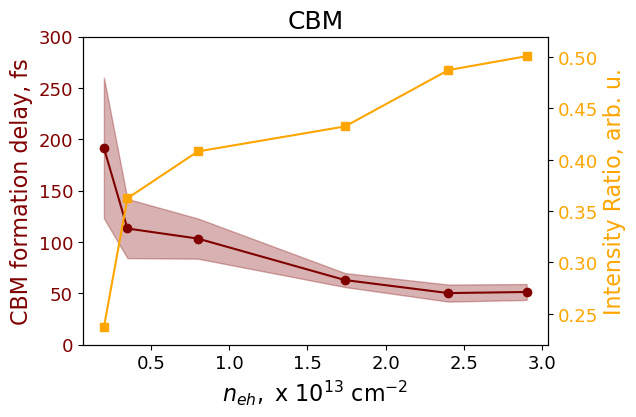

In [383]:
fig, ax1 = plt.subplots(figsize=(6,4))

# Left axis (CBM erf t0 with error shading)
color = 'maroon'
y = cbm_t0s[:,0]
yerr = cbm_t0s[:,1]
#ax1.plot(n, y, marker='o', color=color, label="CBM $t_0$")
#ax1.fill_between(n, y - yerr, y + yerr, color=color, alpha=0.3)

ax1.set_xlabel("$n_{eh},$ x $10^{13}$ cm$^{-2}$", fontsize = 16)
ax1.set_ylabel("CBM formation delay, fs", color=color, fontsize = 16)
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_ylim(0, 300)
ax1.set_title('CBM', fontsize = 18)
ax1.tick_params(axis='both', which='major', labelsize=13)

# CBM erf width
color = 'green'
y = cbm_t0s[:,2]
yerr = cbm_t0s[:,3]
#ax1.plot(n, y, marker='o', color=color, label="CBM $t_0$")
#ax1.fill_between(n, y - yerr, y + yerr, color=color, alpha=0.3)

#plt.plot(n, y, marker = 'o', color=color)
#plt.fill_between(n, y - yerr, y + yerr, color=color alpha = 0.3)

# CBM Rise Time Component (from exponential fitting)
color='maroon'
y = np.asarray(params_cbm_all["tau_rise"])
yerr = errors_cbm_all["tau_rise"]
ax1.plot(n, y, marker = 'o', color=color)
ax1.fill_between(n, y - yerr, y + yerr, color=color, alpha = 0.3)

# Right axis (ratios)
color = 'orange'
ax2 = ax1.twinx()
ax2.plot(n, ratios, marker='s', color=color, label="Ratios")
ax2.set_ylabel("Intensity Ratio, arb. u.", color=color, fontsize = 16)
ax2.tick_params(axis='y', labelcolor=color)
ax2.tick_params(axis='both', which='major', labelsize=13)
ax2.set_ylim(0.22, 0.52)
#ax1.legend(frameon=False)
#ax2.legend(frameon=False)

mpes.save_figure(fig, name = f'cbm_rise_time_expfitting', image_format = 'pdf')

Showing Fit Trends for: biexp (exciton) and exp_rise_biexp_decay (CBM)


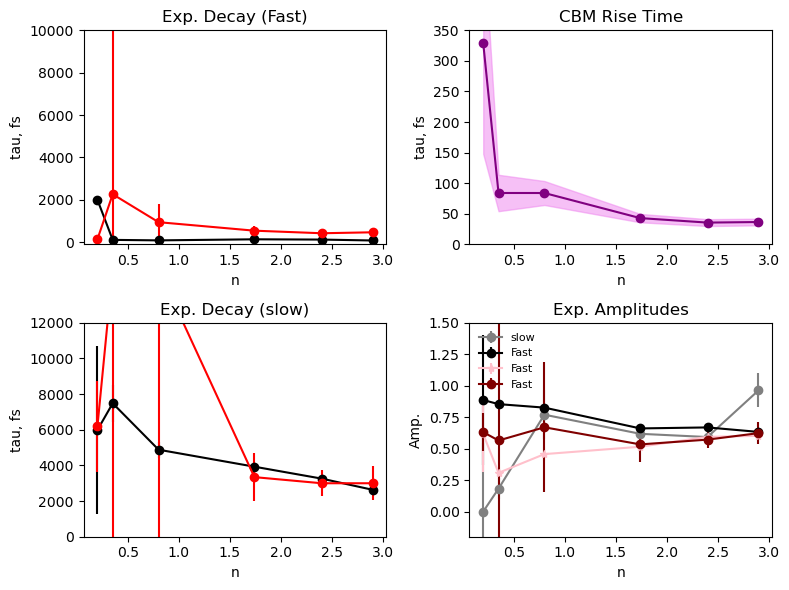

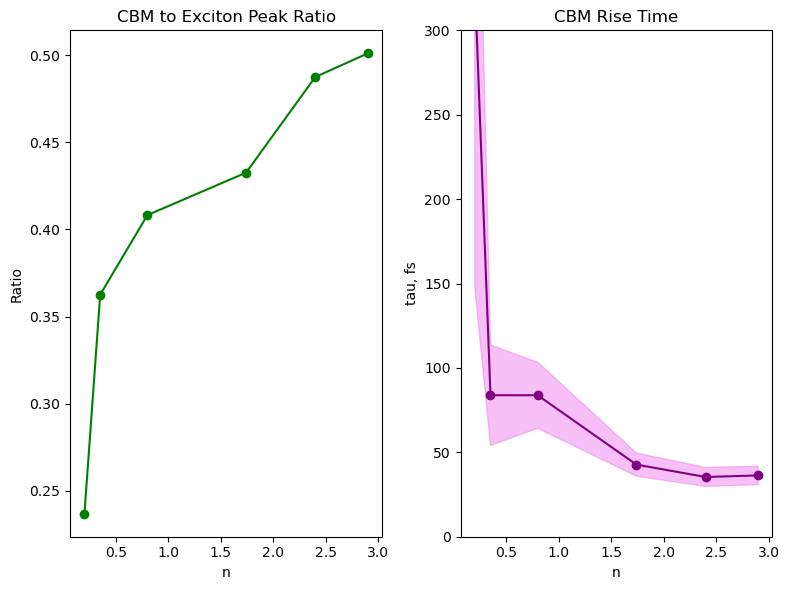

In [319]:
print(f"Showing Fit Trends for: {ex_model} (exciton) and {cbm_model} (CBM)")

fig, ax = plt.subplots(2, 2, figsize=(8,6), sharex=False)
ax = ax.flatten()

n = [p**1 for p in power]
n = fluences

# FAST Exp Decay Component
ax[0].errorbar(n, params_ex_all["tau_decay1"], yerr = errors_ex_all["tau_decay1"], marker = 'o', color = 'k')
ax[0].errorbar(n, params_cbm_all["tau_decay1"], yerr = errors_cbm_all["tau_decay1"], marker = 'o', color = 'r')
ax[0].set_title('Exp. Decay (Fast)')
ax[0].set_ylabel('tau, fs')
ax[0].set_xlabel('n')
ax[0].set_ylim(-100,10000)

# Slow Exp Decay Component
ax[2].errorbar(n, params_ex_all["tau_decay2"], yerr = errors_ex_all["tau_decay2"], marker = 'o', color = 'k')
if cbm_model == 'exp_rise_biexp_decay':
    ax[2].errorbar(n, params_cbm_all["tau_decay2"], yerr = errors_cbm_all["tau_decay2"], marker = 'o', color = 'r')
ax[2].set_title('Exp. Decay (slow)')
ax[2].set_ylabel('tau, fs')
ax[2].set_xlabel('n')
ax[2].set_ylim(0,12000)

# CBM Rise Time Component
y = np.asarray(params_cbm_all["tau_rise"])
yerr = errors_cbm_all["tau_rise"]
ax[1].plot(n, y, marker = 'o', color = 'purple')
ax[1].fill_between(n, y - yerr, y + yerr, color = 'violet', alpha = 0.5)
#ax[1].errorbar(n, params_cbm_all["tau_rise"], yerr = errors_cbm_all["tau_rise"], marker = 'o', color = 'purple')
ax[1].set_ylim(0, 350)
ax[1].set_title('CBM Rise Time')
ax[1].set_ylabel('tau, fs')
ax[1].set_xlabel('n')

# Exp AMPLITUDES Components
ax[3].errorbar(n, params_ex_all["A"], yerr = errors_ex_all["A"], marker = 'o', color = 'grey', label = 'slow')
ax[3].errorbar(n, params_ex_all["B"], yerr = errors_ex_all["B"], marker = 'o', color = 'k', label = 'Fast')
ax[3].errorbar(n, params_cbm_all["A"], yerr = errors_cbm_all["A"], marker = '*', color = 'pink', label = 'Fast')
if cbm_model == 'exp_rise_biexp_decay':
    ax[3].errorbar(n, params_cbm_all["D"], yerr = errors_cbm_all["D"], marker = 'o', color = 'maroon', label = 'Fast')

#ax[3].errorbar(n, 1-params_cbm_all["B"], yerr = errors_cbm_all["D"], marker = 'o', color = 'k', label = 'Fast')

#ax[3].errorbar(n, params_cbm["tau_decay2"], yerr = params_cbm["errors"]["tau_decay2"], marker = '*', color = 'pink', label = 'Fast')
#ax[3].errorbar(n, (1- popt_cbm[:,2]), yerr = perr_cbm[:,2], marker = '*', color = 'r', label = 'Slow')
#ax[3].errorbar(n, popt_cbm[:,0], yerr = perr_cbm[:,0], marker = '*', color = 'purple', label = 'RISE')

ax[3].set_title('Exp. Amplitudes')
ax[3].set_ylabel('Amp.')
ax[3].set_xlabel('n')
ax[3].set_ylim(-.2,1.5)
ax[3].legend(frameon=False, fontsize = 8)

fig.tight_layout()

###
fig, ax = plt.subplots(1, 2, figsize=(8,6), sharex=False)
ax = ax.flatten()

ax[0].plot(n, ratios, marker = 'o', color = 'green')
ax[0].set_title('CBM to Exciton Peak Ratio')
ax[0].set_ylabel('Ratio')
ax[0].set_xlabel('n')

y = np.asarray(params_cbm_all["tau_rise"])
yerr = errors_cbm_all["tau_rise"]
ax[1].plot(n, y, marker = 'o', color = 'purple')
ax[1].fill_between(n, y - yerr, y + yerr, color = 'violet', alpha = 0.5)
ax[1].set_ylim(0, 300)
ax[1].set_title('CBM Rise Time')
ax[1].set_ylabel('tau, fs')
ax[1].set_xlabel('n')
fig.tight_layout()


### Fitting Ex and CBM to Shared Exponentials

0

Fit Results for model: biexp
----------------------------------------
A          =     0.0000 ±  0.0653
tau_decay1 =   192.0246 ± 324.5029
B          =     0.9123 ±  0.0280
tau_decay2 =  5050.0000 ± 472.9285
----------------------------------------

Fit Results for model: exp_rise_biexp_decay
----------------------------------------
A          =     0.5649 ±  0.4704
tau_rise   =   436.5287 ± 364.8707
D          =     0.5610 ±  0.3468
tau_decay1 =   192.0246 ± 324.5029
tau_decay2 =  5050.0000 ± 472.9285
----------------------------------------
1

Fit Results for model: biexp
----------------------------------------
A          =     0.0000 ±  0.0897
tau_decay1 =   617.2041 ± 2633.0440
B          =     0.9260 ±  0.0647
tau_decay2 =  5050.0000 ± 840.8471
----------------------------------------

Fit Results for model: exp_rise_biexp_decay
----------------------------------------
A          =     0.3415 ±  0.2747
tau_rise   =   136.5930 ± 151.8586
D          =     0.1863 ±  0.5650
tau_de

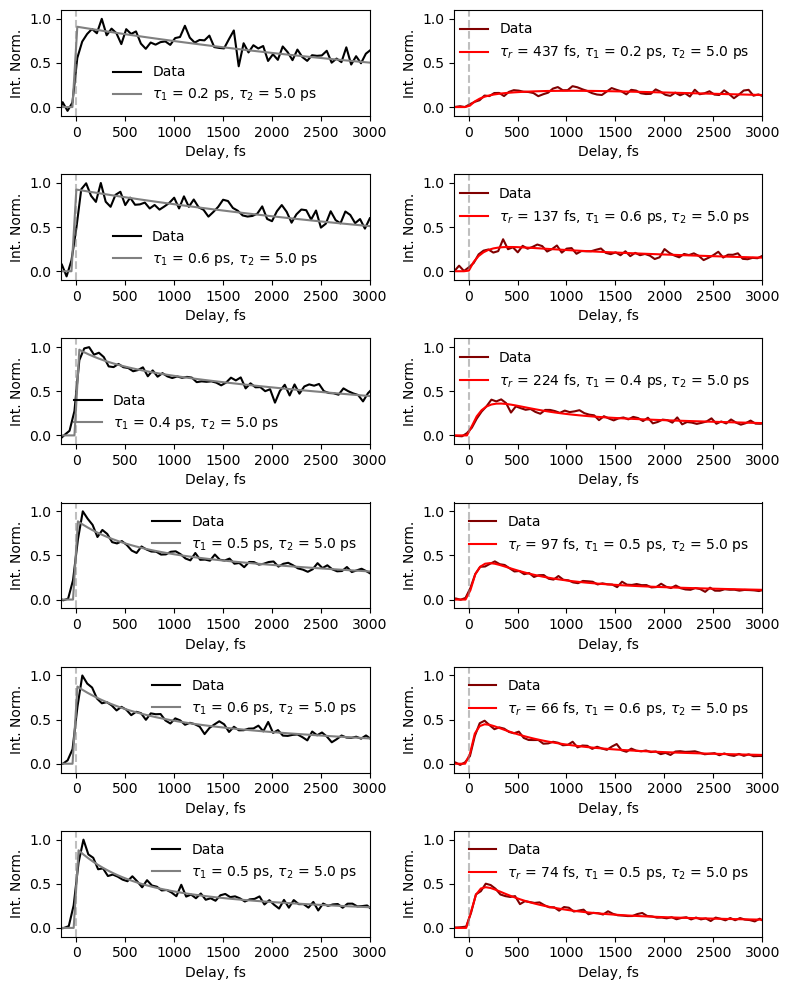

In [ ]:
# Specify Data and Scan Paramters
scans = [9219, 9217, 9218, 9216, 9220, 9228]
power = [8.3, 20.9, 41.7, 65.6, 83.2, 104.7]
fluences = [.2, .35, .8, 1.74, 2.4, 2.9]

E, E_int = [1.35, 2.1], 0.1 # center energies, half of full E integration range

delay_limit = [-200, 3050] # Truncate delay traces
convolve_IRF, fwhm_IRF = True, 80
sigma_IRF = fwhm_IRF/2.355   # Fixed IRF width (fs)

# Exciton Fitting Model
ex_model = 'biexp'
p0_exciton = (.2, 1000, 1, 5000) #A, tau1, B, tau2
lower_bounds_ex, upper_bounds_ex = (0, 0, 0, 10000), (3, 2000, 3, 30000)

# CBM Fitting Model
#cbm_model = 'exp_rise_monoexp_decay'
cbm_model = 'exp_rise_biexp_decay'

if cbm_model == 'exp_rise_monoexp_decay':
    p0_cbm = (2, 200, 1000) #A', 'tau_rise', 'tau_decay'
    lower_bounds_cbm, upper_bounds_cbm = (0, 0, 0), (2, 2000, 30000)
elif cbm_model == 'exp_rise_biexp_decay':
    p0_cbm = (1, 200, 0, 2000, 10000) #C, tau_rise, D, tau_decay1, tau_decay2
    lower_bounds_cbm, upper_bounds_cbm = (0, 0, 0, 0, 1000), (3, 300,  1, 5000, 30000)

def combined_model(t, A, tau_decay1, B, tau_decay2, C, tau_rise, D):
    exciton = mpes.biexp(t, A, tau_decay1, B, tau_decay2)
    cb = mpes.exp_rise_biexp_decay(t, C, tau_rise, D, tau_decay1, tau_decay2)

    return np.concatenate((exciton, cb))  # Stack both signals

# Initalize Fitting Arrays
params_ex_all, errors_ex_all = defaultdict(list), defaultdict(list)
params_cbm_all, errors_cbm_all = defaultdict(list), defaultdict(list)
ratios = np.zeros(len(scans))

# Initialize Figure
fig, ax = plt.subplots(6, 2)
fig.set_size_inches(8, 10, forward=False)
ax = ax.flatten()

# Plot and Perform Fits
for s in range(len(scans)):
    print(s)

    # Load in the Data
    res = phoibos.load_data(data_path, scans[s], force_offset=False, scan_info = scan_info, energy_offset=19.7, delay_offset=0)
    delay_axis = res.delay.values
    delay_axis = res.delay.loc[{"delay":slice(delay_limit[0], delay_limit[1])}].values

    trace_1 = mpes.get_time_trace(res, E[0], E_int, 0, 24, norm_trace = False, subtract_neg = True, neg_delays = [-600, -200])
    trace_1 = trace_1.loc[{"delay":slice(delay_limit[0],delay_limit[1])}]

    trace_2 = mpes.get_time_trace(res, E[1], E_int, 0, 24, norm_trace = False, subtract_neg = True, neg_delays = [-600, -200])
    trace_2 = trace_2.loc[{"delay":slice(delay_limit[0],delay_limit[1])}]

    norm_factor = np.max(trace_1)
    trace_1 = trace_1/norm_factor
    trace_2 = trace_2/norm_factor

    traces_combined = np.concatenate((trace_1, trace_2))

    # Fit Combined Data Together
    initial_guess_combined = [1, 250, 1, 5000, 1, 200, .5] # A, tau1, B, tau2, C, tau_rise, D
    bnds_combined = [[0, 50, 0, 4950, 0, 0, 0], [2, 10000, 2, 5050, 4, 1000, 1]]
    
    popt_comb, pcov_comb = curve_fit(combined_model, delay_axis, traces_combined, p0=initial_guess_combined, bounds = bnds_combined)
    perr_comb = np.sqrt(np.diag(pcov_comb))

    # Exciton Fitting    
    #popt_exciton, pcov, fit_curve_1 = mpes.fit_time_trace(ex_model, delay_axis, trace_1, p0=p0_exciton, bounds = [lower_bounds_ex, upper_bounds_ex], convolve = convolve_IRF, sigma_IRF = sigma_IRF)
    #perr_exciton = np.sqrt(np.diag(pcov))
    popt_exciton = popt_comb[0:3+1]
    pcov_exciton = pcov_comb[0:3+1]

    perr_exciton = perr_comb[0:3+1]
    params_ex, label_ex = mpes.print_fit_results(ex_model, popt_exciton, pcov_exciton)
            
    # CBM Fitting
    #popt_cbm, pcov, fit_curve_2 = mpes.fit_time_trace(cbm_model, delay_axis, trace_2, p0=p0_cbm, bounds = [lower_bounds_cbm, upper_bounds_cbm], convolve = convolve_IRF, sigma_IRF = sigma_IRF)
    #perr_cbm = np.sqrt(np.diag(pcov))
    indices = [4, 5, 6, 1, 3]  
    popt_cbm = popt_comb[np.ix_(indices)]
    pcov_cbm = pcov_comb[np.ix_(indices, indices)]

    perr_cbm = perr_comb[np.ix_(indices)]
    params_cbm, label_cbm = mpes.print_fit_results(cbm_model, popt_cbm, pcov_cbm)

    # Save Fitting Parameters
    # Store exciton params
    for key, val in params_ex.items():
        if key == "errors":
            for err_key, err_val in params_ex["errors"].items():
                errors_ex_all[err_key].append(err_val)
        else:
            params_ex_all[key].append(val)

    # Store CBM params
    for key, val in params_cbm.items():
        if key == "errors":
            for err_key, err_val in params_cbm["errors"].items():
                errors_cbm_all[err_key].append(err_val)
        else:
            params_cbm_all[key].append(val)

    # Generate fitted curves
    A, tau1, B, tau2, C, tau_rise, D = popt_comb
    fit_curve_1, fit_curve_2 = mpes.biexp(delay_axis, A, tau1, B, tau2), mpes.exp_rise_biexp_decay(delay_axis, C, tau_rise, D, tau1, tau2)
    
    ratios[s] =  np.max(fit_curve_2) / np.max(fit_curve_1)

    #label_ex = fr"$\tau_{1}$ = {popt_exciton[1]:.0f} fs, $\tau_{2}$ = {popt_exciton[3]/1000:.1f} ps"
    #label_cbm = fr"$\tau_{{r}}$ = {popt_cbm[1]:.0f} fs, $\tau_{1}$ = {popt_cbm[2]/1000:.1f} ps"
    #label_ex = fr"$\tau_{1}$ = {params_ex['tau1']/1000:.1f} ps, $\tau_{2}$ = {params_ex['tau2']/1000:.1f} ps"
    #label_cbm = fr"$\tau_{{r}}$ = {params_cbm['tau_rise']:.0f} fs, $\tau_{1}$ = {params_cbm['tau_decay1']/1000:.1f} ps, $\tau_{2}$ = {params_cbm['tau_decay2']/1000:.1f} ps"

    # Plot Data and Fits
    ax[2*s].plot(delay_axis, trace_1, linestyle = 'solid', color = 'black', linewidth = 1.5, label = 'Data')
    ax[2*s].plot(delay_axis, fit_curve_1, linestyle = 'solid', color = 'gray', linewidth = 1.5, label = label_ex)
    ax[2*s].axvline(0, linestyle='--', color='gray', alpha=0.5)
    ax[2*s].legend(frameon=False)

    ax[2*s+1].plot(delay_axis, trace_2, linestyle = 'solid', color = 'maroon', linewidth = 1.5, label = 'Data')
    ax[2*s+1].plot(delay_axis, fit_curve_2, linestyle = 'solid', color = 'red', linewidth = 1.5, label = label_cbm)
    ax[2*s+1].axvline(0, linestyle='--', color='gray', alpha=0.5)
    ax[2*s+1].legend(frameon=False)

    ax[2*s].set_ylabel('Int. Norm.')
    ax[2*s].set_xlabel('Delay, fs')
    ax[2*s].set_xlim(-150, 3000)
    ax[2*s].set_ylim(-0.1,1.1)
    ax[2*s+1].set_ylabel('Int. Norm.')
    ax[2*s+1].set_xlabel('Delay, fs')
    ax[2*s+1].set_xlim(-150, 3000)
    ax[2*s+1].set_ylim(-0.1,1.1)

fig.tight_layout()